<a href="https://colab.research.google.com/github/MRB1996/Titanic-Learning-From-Disaster/blob/master/Titanic_Learning_From_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic - Learning From Disaster

* Melchior Reihlen-Börgers
* [GitHub](https://github.com/MRB1996/Titanic-Learning-From-Disaster)

In [157]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
os.getcwd()

os.chdir("/content/drive/My Drive/Titanic Data Science Challenge")

## Import Data

In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [7]:
for index, col_name in enumerate(train.columns):
  print(index, col_name)

0 PassengerId
1 Survived
2 Pclass
3 Name
4 Sex
5 Age
6 SibSp
7 Parch
8 Ticket
9 Fare
10 Cabin
11 Embarked


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(6), object(4)
memory usage: 83.7+ KB


## Change Data Types

In [19]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


**Recode Sex**

In [0]:
train.loc[:,"Sex"] = train.loc[:,"Sex"].map({"female": 1, "male": 0})

In [0]:
test.loc[:,"Sex"] = test.loc[:,"Sex"].map({"female": 1, "male": 0})

## Assess Cleaniness Of Data

**1. How many rows are empty?**

In [13]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Descriptive Data Analytics

### Survived

1. How many people survived vs. died?

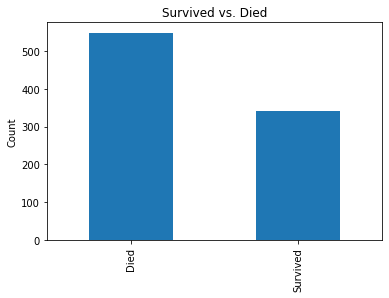

In [140]:
train.loc[:,"Survived"].map({0: "Died", 1: "Survived"}).value_counts().plot(kind = "bar")
plt.title("Survived vs. Died")
plt.ylabel("Count")
plt.show()

2. How old where people that survived, died and in total?


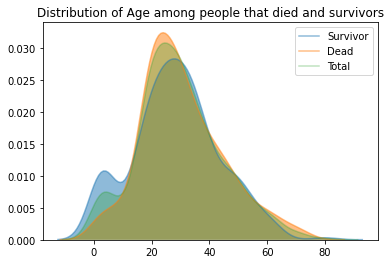

In [163]:
h1 = train[train["Survived"] == 1].loc[:,"Age"]
h2 = train[train["Survived"] == 0].loc[:,"Age"]
h3 = train.loc[:,"Age"]

sns.kdeplot(h1, alpha=0.5, label='Survivor', shade = True)
sns.kdeplot(h2, alpha=0.5, label='Dead', shade = True)
sns.kdeplot(h3, alpha= 0.3, label='Total', shade = True)
plt.legend(loc = 1)
plt.title("Distribution of Age among people that died and survivors")
plt.show()

### Class

1. How many passengers are in each class?

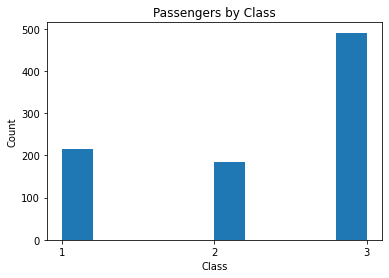

In [50]:
plt.hist(train.loc[:,"Pclass"])
plt.xticks([1,2,3])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Passengers by Class")
plt.show()

2. How many of the passengers are male/female by class?

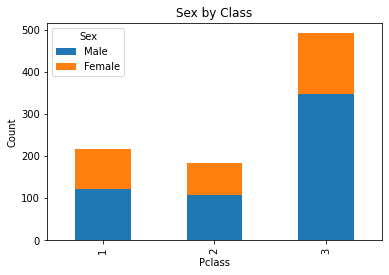

In [100]:
train.loc[:,["Sex", "Pclass"]].groupby("Pclass")["Sex"].value_counts().unstack().rename(columns = {0: "Male", 1:"Female"}).plot(kind = "bar", stacked = True)
plt.title("Sex by Class")
plt.ylabel("Count")
plt.show()

3. How many of the passengers survived by class?

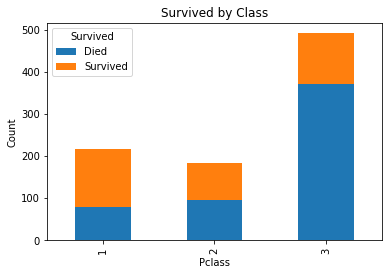

In [102]:
train.loc[:,["Survived", "Pclass"]].groupby("Pclass")["Survived"].value_counts().unstack().rename(columns = {0: "Died", 1:"Survived"}).plot(kind = "bar", stacked = True)
plt.title("Survived by Class")
plt.ylabel("Count")
plt.show()

4. What is the ratio of survivors to people that died by class?

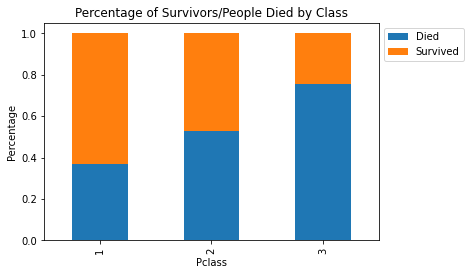

In [135]:
df.div(df.sum(axis = 1), axis = 0).plot(kind = "bar", stacked = True)
plt.ylabel("Percentage")
plt.title("Percentage of Survivors/People Died by Class")
plt.legend(loc = 0, bbox_to_anchor = (1, 1))
plt.show()


### Ticket

In [29]:
percentage_unique = len(train.loc[:,"Ticket"].unique())/train.shape[0]

print("{:.2f}% of Tickets are unique.".format(percentage_unique*100))

76.43% of Tickets are unique.


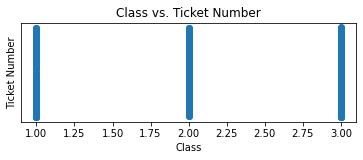

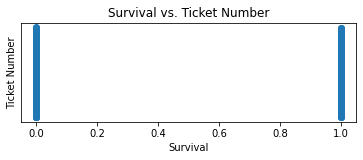

In [42]:
plt.subplot(2, 1, 1)
plt.scatter(x = train.loc[:,"Pclass"], y = train.loc[:,"Ticket"])
plt.yticks([])
plt.xlabel("Class")
plt.ylabel("Ticket Number")
plt.title("Class vs. Ticket Number")
plt.show()

plt.subplot(2, 1, 2)
plt.scatter(x = train.loc[:,"Survived"], y = train.loc[:,"Ticket"])
plt.yticks([])
plt.xlabel("Survival")
plt.ylabel("Ticket Number")
plt.title("Survival vs. Ticket Number")
plt.show()




*   Tickets are mostely unique
*   Tickets does not correlate with major variables

